In [1]:
%matplotlib qt
%load_ext autoreload
%autoreload 2



# Source localization with MNE, dSPM, sLORETA, and eLORETA

The aim of this tutorial is to teach you how to compute and apply a linear
minimum-norm inverse method on evoked/raw/epochs data.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
import sys; sys.path.insert(0, '../')
from invert import Solver

Process MEG data



In [3]:
data_path = sample.data_path()
raw_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014')

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('meg', 'eog'), baseline=baseline, reject=reject)

Opening raw data file C:\Users\Lukas\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated


## Compute regularized noise covariance
For more details see `tut-compute-covariance`.



In [4]:
noise_cov = mne.compute_covariance(
    epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

Loading data for 72 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
17 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 2.8e-09 (2.2e-16 eps * 305 dim * 4.2e+04 

## Compute the evoked response
Let's just use the MEG channels for simplicity.



Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


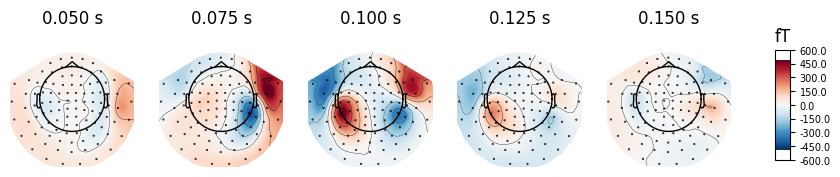

In [5]:
evoked = epochs.average().pick('meg')
evoked.plot(time_unit='s')
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag')

It's also a good idea to look at whitened data:



Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 203 dim * 3.5  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.98  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank={'grad': 203, 'mag': 99, 'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)


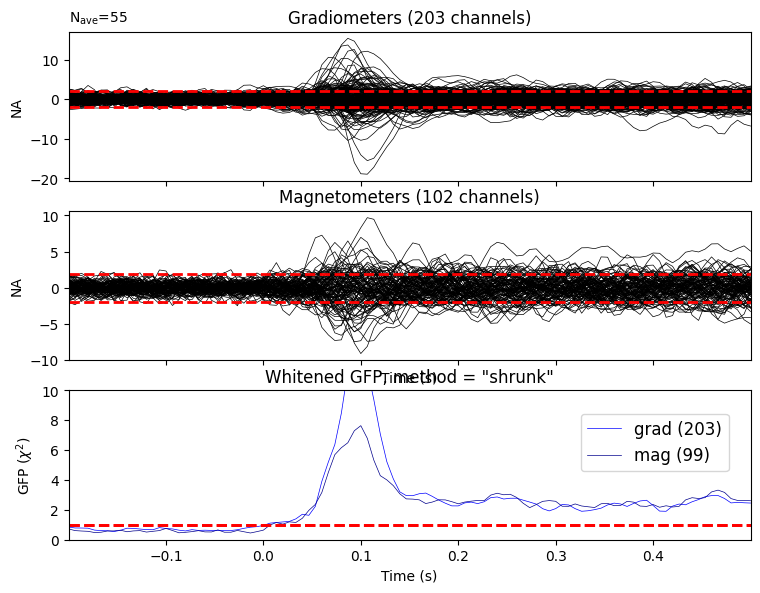

In [6]:
evoked.plot_white(noise_cov, time_unit='s')

## Inverse modeling: MNE/dSPM on evoked and raw data
Here we first read the forward solution. You will likely need to compute
one for your own data -- see `tut-forward` for information on how
to do it.



In [7]:
fname_fwd = data_path / 'MEG' / 'sample' / 'sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd)

Reading forward solution from C:\Users\Lukas\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


Next, we make an MEG inverse operator.



In [8]:
fwd = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                            use_cps=True, verbose=0)
fwd["sol"]["data"].shape

(306, 7498)

## Compute inverse solution
We can use this to compute the inverse solution and obtain source time
courses:



In [47]:
import os
from time import time
subject = "sample"
subjects_dir = os.path.join(str(data_path), "subjects")
pp = dict(surface="inflated", hemi="both", verbose=0, subject=subject, subjects_dir=subjects_dir)

solver = Solver("HOCMCMV")
start = time()
solver.make_inverse_operator(fwd, evoked, alpha=0.1)
end1 = time()
stc = solver.apply_inverse_operator(evoked)
end2 = time()

print(f"make: {(end1-start):.2f}, apply: {(end2-end1):.2f}")

stc.subject = subject
stc.plot(**pp, brain_kwargs=dict(title=solver.name))

make: 38.75, apply: 0.22


Using control points [5.95765563e-12 7.34346394e-12 1.41216831e-11]
Using control points [3.57336063e-12 4.05805461e-12 6.02373900e-12]
Using control points [3.63497180e-12 3.86602662e-12 5.00934035e-12]


## Compute inverse solution
We can use this to compute the inverse solution and obtain source time
courses:



In [21]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc, residual = apply_inverse(evoked, inverse_operator, lambda2,
                              method=method, pick_ori=None,
                              return_residual=True, verbose=True)
stc.plot(**pp, brain_kwargs=dict(title=method))

NameError: name 'inverse_operator' is not defined

## Visualization
We can look at different dipole activations:



In [ ]:
fig, ax = plt.subplots()
ax.plot(1e3 * stc.times, stc.data[::100, :].T)
ax.set(xlabel='time (ms)', ylabel='%s value' % method)

Examine the original data and the residual after fitting:



In [ ]:
fig, axes = plt.subplots(2, 1)
evoked.plot(axes=axes)
for ax in axes:
    for text in list(ax.texts):
        text.remove()
    for line in ax.lines:
        line.set_color('#98df81')
residual.plot(axes=axes)

Here we use peak getter to move visualization to the time point of the peak
and draw a marker at the maximum peak vertex.



In [ ]:
vertno_max, time_max = stc.get_peak(hemi='rh')

subjects_dir = data_path / 'subjects'
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
brain = stc.plot(**surfer_kwargs)
brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',
               scale_factor=0.6, alpha=0.5)
brain.add_text(0.1, 0.9, 'dSPM (plus location of maximal activation)', 'title',
               font_size=14)

# The documentation website's movie is generated with:
# brain.save_movie(..., tmin=0.05, tmax=0.15, interpolation='linear',
#                  time_dilation=20, framerate=10, time_viewer=True)

There are many other ways to visualize and work with source data, see
for example:

- `tut-viz-stcs`
- `ex-morph-surface`
- `ex-morph-volume`
- `ex-vector-mne-solution`
- `tut-dipole-orientations`
- `tut-mne-fixed-free`
- `examples using apply_inverse
  <sphx_glr_backreferences_mne.minimum_norm.apply_inverse>`.

